# DenseNet-121 MNIST Digits Classifier

### Network Architecture

The network in this notebook is an implementation of the DenseNet-121 [1] architecture on the MNIST digits dataset (http://yann.lecun.com/exdb/mnist/) to train a handwritten digit classifier.  

The following figure illustrates the main concept of DenseNet: within each "dense" block, each layer is connected with each previous layer -- the feature maps are concatenated.


![](images/densenet/densenet-fig-2.jpg)

Note that this is somewhat related yet very different to ResNets. ResNets have skip connections approx. between every other layer (but don't connect all layers with each other). Also, ResNets skip connections work via addition

$$\mathbf{x}_{\ell}=H_{\ell}\left(\mathbf{X}_{\ell-1}\right)+\mathbf{X}_{\ell-1}$$,

whereas $H_{\ell}(\cdot)$ can be a composite function  of operations such as Batch Normalization (BN), rectified linear units (ReLU), Pooling, or Convolution (Conv).

In DenseNets, all the previous feature maps $\mathbf{X}_{0}, \dots, \mathbf{X}_{\ell}-1$ of a feature map $\mathbf{X}_{\ell}$ are concatenated:

$$\mathbf{x}_{\ell}=H_{\ell}\left(\left[\mathbf{x}_{0}, \mathbf{x}_{1}, \ldots, \mathbf{x}_{\ell-1}\right]\right).$$

Furthermore, in this particular notebook, we are considering the DenseNet-121, which is depicted below:



![](images/densenet/densenet-tab-1-dnet121.jpg)

**References**
    
- [1] Huang, G., Liu, Z., Van Der Maaten, L., & Weinberger, K. Q. (2017). Densely connected convolutional networks. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 4700-4708), http://openaccess.thecvf.com/content_cvpr_2017/html/Huang_Densely_Connected_Convolutional_CVPR_2017_paper.html

- [2] http://yann.lecun.com/exdb/mnist/

In [1]:
import sys
sys.path.append("/Users/ZRC")
sys.path

['/Users/ZRC/miniconda3/envs/tryit/lib/python36.zip',
 '/Users/ZRC/miniconda3/envs/tryit/lib/python3.6',
 '/Users/ZRC/miniconda3/envs/tryit/lib/python3.6/lib-dynload',
 '',
 '/Users/ZRC/miniconda3/envs/tryit/lib/python3.6/site-packages',
 '/Users/ZRC/miniconda3/envs/tryit/lib/python3.6/site-packages/IPython/extensions',
 '/Users/ZRC/.ipython',
 '/Users/ZRC']

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler
from torch.utils.data import Subset


from torchvision import datasets
from torchvision import transforms

from torchsummary import summary

In [5]:
from coke.visualization.image import show_batch

## Model Settings

In [6]:
# Hyperparameters

BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 0.0001
RANDOM_SEED = 7

# Architecture
NUM_CLASSES = 10
GRAYSCALE = True

# # other
# torch.cuda.empty_cache()
DEVICE = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")

In [7]:
data_transforms = {"train": transforms.Compose([
                            transforms.Resize((32,32)),
                            transforms.ToTensor()]),
                    "test": transforms.Compose([
                            transforms.Resize((32,32)),
                            transforms.ToTensor()])
                   }

In [2]:
train_indices = torch.arange(0, 59000)
valid_indices = torch.arange(59000, 60000)



train_and_valida_dataset = datasets.MNIST(root = "data",
                                train = True,
                                transform = data_transforms["train"],
                                download=True)

test_dataset = datasets.MNIST(root = "data",
                                train = False,
                                transform = data_transforms["test"],
                                download=False)

train_dataset = Subset(train_and_valida_dataset, train_indices)
valid_dataset = Subset(train_and_valida_dataset, valid_indices)




train_dataloader = DataLoader(dataset = train_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=4)

valid_dataloader = DataLoader(dataset = valid_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=4)

test_dataloader = DataLoader(dataset = test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=4)

data_loader = {"train": train_dataloader, 
               "val": valid_dataloader,
               "test": test_dataloader}

torch.Size([64, 1, 32, 32]) torch.Size([64])


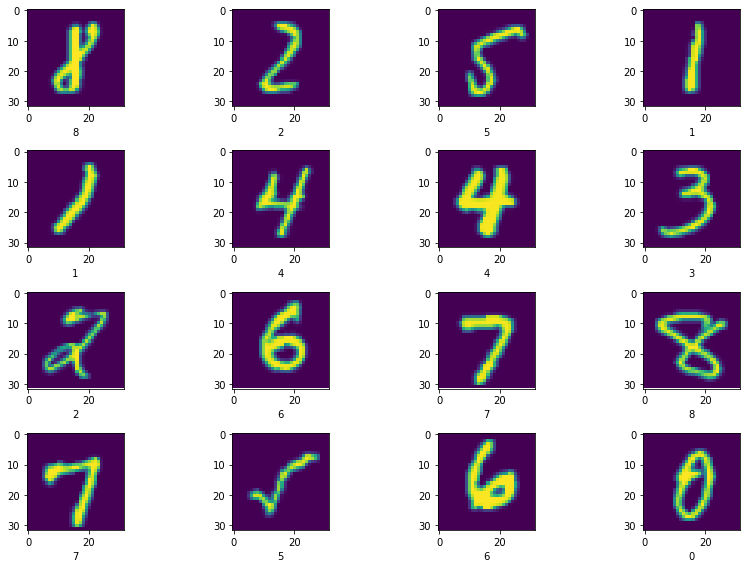

In [9]:
batch_samples,labels = next(iter(train_dataloader))
print(batch_samples.size(),labels.size())
show_batch(batch_samples.squeeze(), labels.numpy(), (4,4))

torch.Size([64, 1, 32, 32]) torch.Size([64])


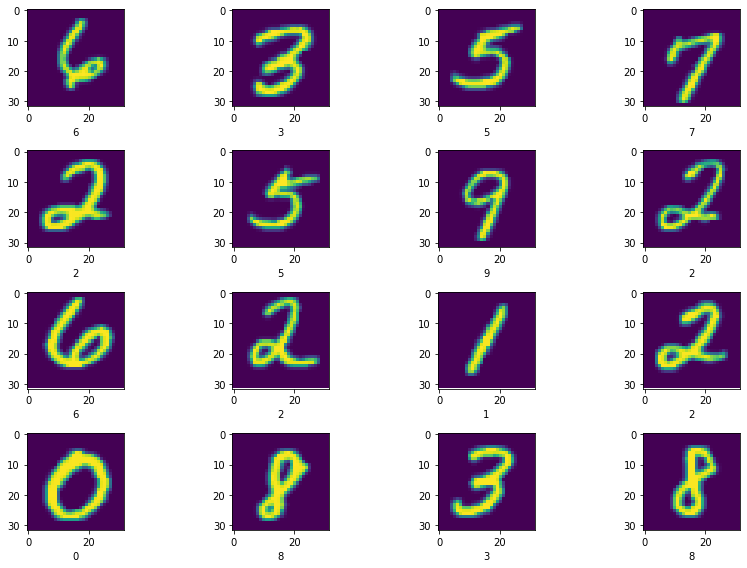

In [184]:
batch_samples,labels = next(iter(valid_dataloader))
print(batch_samples.shape,labels.shape)
show_batch(batch_samples.squeeze(), labels.numpy(), (4,4))

torch.Size([64, 1, 32, 32]) torch.Size([64])


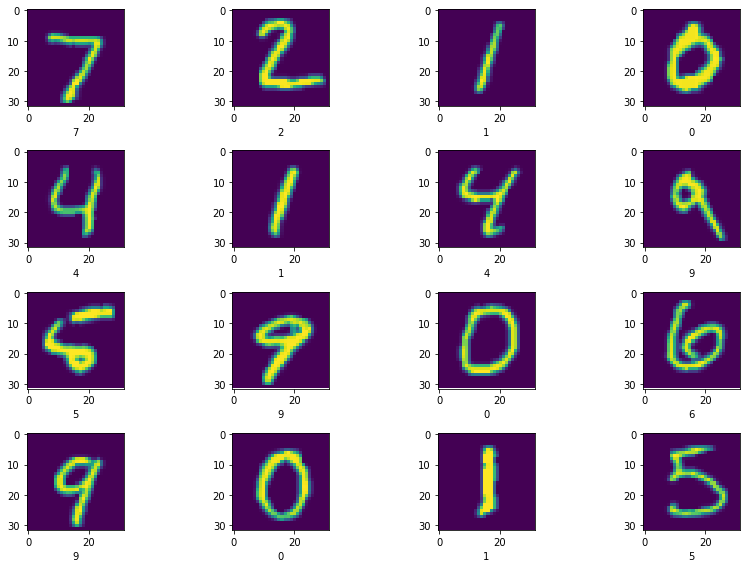

In [185]:
batch_samples,labels = next(iter(test_dataloader))
print(batch_samples.shape,labels.shape)
show_batch(batch_samples.squeeze(), labels.numpy(), (4,4))

## Model

![](images/densenet/densenet-arch.png)

### Composite function

Each CONV block in the network representations in the paper (and in the blog) corresponds to an operation of —

<center>BatchNorm→ReLU→Conv</center>


In [9]:
def composite(input_features,out_features, kernel_size, stride = 1, padding = 0):
    
    return torch.nn.Sequential(
            torch.nn.BatchNorm2d(input_features),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(input_features, 
                            out_features, 
                            kernel_size=kernel_size, 
                            stride=stride,
                            padding = padding,
                            bias=False))

### Dense layer
Each dense-layer consists of 2 convolutional operations -
- 1 X 1 CONV (conventional conv operation for extracting features)
- 3 X 3 CONV (bringing down the feature depth/channel count)

![denselayer.png](images/densenet/denselayer.png)

In [10]:
class DenseLayer(torch.nn.Module):
    def __init__(self, num_input_features, growth_rate = 32, bn_size = 2, drop_rate = 0):
        super(DenseLayer, self).__init__()
        
        self.composite_1 = composite(input_features = num_input_features,
                                     out_features = bn_size * growth_rate,
                                     kernel_size = 1,
                                     stride = 1,
                                     padding = 0)
        
        
        
        self.composite_2 = composite(input_features = bn_size * growth_rate,
                                     out_features = growth_rate,
                                     kernel_size = 3,
                                     stride = 1,
                                     padding = 1)
        
        self.drop_rate = drop_rate
            
    def forward(self, *prev_features):
        
        ## concate in channels
        concated_features = torch.cat(prev_features, 1)        
        bottleneck_output = self.composite_1(concated_features)
        new_features = self.composite_2(bottleneck_output)
        
        if self.drop_rate:
            new_features = F.dropout(new_features, p=self.drop_rate, training= self.training)
            
        return new_features

In [11]:
def test_DenseLayer():
    model = DenseLayer(num_input_features = 32, growth_rate = 32, bn_size = 2).to(DEVICE)
    summary(model, [(32,32,32)])
test_DenseLayer()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1           [-1, 32, 32, 32]              64
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]           2,048
       BatchNorm2d-4           [-1, 64, 32, 32]             128
              ReLU-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 32, 32, 32]          18,432
Total params: 20,672
Trainable params: 20,672
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.12
Forward/backward pass size (MB): 2.25
Params size (MB): 0.08
Estimated Total Size (MB): 2.45
----------------------------------------------------------------


### Dense block

The concept of dense connections has been portrayed in dense blocks. A dense block comprises n dense layers. These dense layers are connected using a dense circuitry such that each dense layer receives feature maps from all preceding layers and passes it’s feature maps to all subsequent layers. The dimensions of the features (width, height) stay the same in a dense block.

![](images/densenet/denseblock.png)

In [12]:
class DenseBlock(torch.nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(DenseBlock, self).__init__()
        
        self.layers = torch.nn.ModuleList([
            DenseLayer(
            num_input_features + i * growth_rate,
            growth_rate = growth_rate,
            bn_size = bn_size,
            drop_rate = drop_rate,
            ) for i in range(num_layers)        
        ])
    
    def forward(self, x):
        x = [x]
        for layer in self.layers:
            x.append(layer(*x))
        
#         print(torch.cat(x,1).size()) # 64 + 6*32 = 256
        return torch.cat(x,1)

In [17]:
def test_DenseBlock():
    model = DenseBlock(num_layers = 6, num_input_features = 64, bn_size = 2, growth_rate = 32, drop_rate = 0)
    model.to(DEVICE)
    summary(model, (64,7,7))

test_DenseBlock()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1             [-1, 64, 7, 7]             128
              ReLU-2             [-1, 64, 7, 7]               0
            Conv2d-3             [-1, 64, 7, 7]           4,096
       BatchNorm2d-4             [-1, 64, 7, 7]             128
              ReLU-5             [-1, 64, 7, 7]               0
            Conv2d-6             [-1, 32, 7, 7]          18,432
        DenseLayer-7             [-1, 32, 7, 7]               0
       BatchNorm2d-8             [-1, 96, 7, 7]             192
              ReLU-9             [-1, 96, 7, 7]               0
           Conv2d-10             [-1, 64, 7, 7]           6,144
      BatchNorm2d-11             [-1, 64, 7, 7]             128
             ReLU-12             [-1, 64, 7, 7]               0
           Conv2d-13             [-1, 32, 7, 7]          18,432
       DenseLayer-14             [-1, 3

## Transition layer

At the end of each dense block, the number of feature-maps accumulates to a value of — input features + (number of dense layers x growth rate). So for 64 channel features entering a dense block of 6 dense-layers of growth rate 32, the number of channels accumulated at the end of the block will be — 
64 + (6 x 32) = 256. To bring down this channel count, a transition layer (or block) is added between two dense blocks. The transition layer consists of -

- 1 X 1 CONV operation: The 1 X 1 CONV operation reduces the channel count to half.
- 2 X 2 AVG POOL operation: The 2 X 2 AVG POOL layer is responsible for downsampling the features in terms of the width and height.

![densenet-transition.png](images/densenet/densenet-transition.png)

In [18]:
class Transition(torch.nn.Module):
    """
    To bring down previous channel count
    """
    def __init__(self, num_input_features, num_output_features):
        super(Transition, self).__init__()
        self.composite = composite(input_features = num_input_features,
                                   out_features = num_output_features, 
                                   kernel_size = 1, 
                                   stride = 1, 
                                   padding = 0)
        self.avg_pool = torch.nn.AvgPool2d(kernel_size=(2,2),
                                          stride = (2,2))
        
    def forward(self, x):
        return self.avg_pool(self.composite(x))    

In [19]:
def test_trainsition():
    model = Transition(256,128)
    model.to(DEVICE)
    summary(model, (256,32,32))
test_trainsition()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [-1, 256, 32, 32]             512
              ReLU-2          [-1, 256, 32, 32]               0
            Conv2d-3          [-1, 128, 32, 32]          32,768
         AvgPool2d-4          [-1, 128, 16, 16]               0
Total params: 33,280
Trainable params: 33,280
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.00
Forward/backward pass size (MB): 5.25
Params size (MB): 0.13
Estimated Total Size (MB): 6.38
----------------------------------------------------------------


## Full network
As can be seen in the diagram below, the authors have chosen different number of dense layers for each of the three dense block.

![densenet-fullnet.png](images/densenet/densenet-fullnet.png)

In [22]:
class DenseNetZrc(torch.nn.Module):
    """
    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each dense block
        num_init_featuremaps (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
    """
    
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_featuremaps=64, bn_size=4, drop_rate=0, num_classes=1000, grayscale=False):
        super(DenseNetZrc, self).__init__()
        
        if grayscale:
            in_channels = 1
        else:
            in_channels = 3
            
        self.features = torch.nn.Sequential(OrderedDict([
            ( "conv_0", torch.nn.Conv2d(in_channels = in_channels,
                                       out_channels = num_init_featuremaps,
                                       kernel_size = 7,
                                       stride = 2,
                                       padding = 3, 
                                       bias = False) ),
            ( 'norm0',torch.nn.BatchNorm2d(num_features = num_init_featuremaps) ),
            ( 'relu0', torch.nn.ReLU(inplace = True) ),
            ( 'pool0', torch.nn.MaxPool2d(kernel_size = 3, 
                                          stride = 2, 
                                          padding = 1) )
        ]))  # [64, 7, 7] 
        
        
        num_features = num_init_featuremaps

        
        for index, num_layers in enumerate(block_config):
            
            dense_block = DenseBlock(num_layers = num_layers, 
                               num_input_features = num_features, 
                               bn_size = bn_size, 
                               growth_rate = growth_rate, 
                               drop_rate = drop_rate)
            
            self.features.add_module(
                "dense_block_{}".format(index+1), dense_block)
            num_features = num_features + num_layers * growth_rate
            
            if index != len(block_config) - 1:
                transition = Transition(num_input_features = num_features,
                                        num_output_features = num_features // 2)
                self.features.add_module(
                    "transition_{}".format(index+1), transition)
                
                num_features = num_features // 2
        
        
        # Final Batch Norm
        self.features.add_module("norm5",torch.nn.BatchNorm2d(num_features))
        self.classifier = torch.nn.Linear(num_features, num_classes)
        
        #############################################
        # initialize the weight
        #############################################
        for name,module in self.named_modules():
            if isinstance(module, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(module.weight)
            elif isinstance(module, torch.nn.BatchNorm2d):
                torch.nn.init.constant_(module.weight, 1)
                torch.nn.init.constant_(module.bias, 0)
            elif isinstance(module, torch.nn.Linear):
                torch.nn.init.constant_(module.bias, 0)
                
    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        logits = self.classifier(out)
        probas = F.softmax(logits, dim=1)
        
        return logits, probas        

In [23]:
def test_DenseNetZrc():
    model = DenseNetZrc(num_classes=10)
    model = model.to(DEVICE)
    summary(model, (3,32,32))

test_DenseNetZrc()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
       BatchNorm2d-5             [-1, 64, 8, 8]             128
              ReLU-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]           8,192
       BatchNorm2d-8            [-1, 128, 8, 8]             256
              ReLU-9            [-1, 128, 8, 8]               0
           Conv2d-10             [-1, 32, 8, 8]          36,864
       DenseLayer-11             [-1, 32, 8, 8]               0
      BatchNorm2d-12             [-1, 96, 8, 8]             192
             ReLU-13             [-1, 96, 8, 8]               0
           Conv2d-14            [-1, 12

In [24]:
model = DenseNetZrc(num_classes=NUM_CLASSES, grayscale=GRAYSCALE)
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [25]:
def compute_accuracy(model, data_loader, device):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [26]:
def train_model(model, data_loader, optimizer, num_epochs,batch_size, device,metric_func, random_seed = 7):
    # Manual seed for deterministic data loader
    torch.manual_seed(random_seed)
    
    loss_list = []
    train_acc_list, valid_acc_list = [], []
    
    for epoch in range(num_epochs):
        # set training mode
        model.train() 
        for batch_idx, (features, targets) in enumerate(data_loader["train"]):
            features = features.to(device)
            targets = targets.to(device)


            ## forward pass
            logits, probas = model(features)
            loss = F.cross_entropy(logits,targets)

            # backward pass
            # clear the gradients of all tensors being optimized
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ### Login
            loss_list.append(loss.item())
            if not batch_idx % 50:
                print ('Epoch: {0:03d}/{1:03d} | Batch {2:03d}/{3:03d} | Loss: {4:.2f}'.format(
                    epoch+1, num_epochs, batch_idx, 
                         len(train_dataset)//batch_size, loss))

        with torch.set_grad_enabled(False):
            train_acc = metric_func(model, data_loader["train"], device)
            valid_acc = metric_func(model, data_loader["val"], device)
            
            print('Epoch: {0:03d}/{1:03d} training accuracy: {2:.2f}'.format(
                  epoch+1, num_epochs, train_acc))
            
            print('Epoch: {0:03d}/{1:03d} validation accuracy: {2:.2f}'.format(
                  epoch+1, num_epochs, valid_acc))
            
            train_acc_list.append(train_acc)
            valid_acc_list.append(valid_acc)
            
    return loss_list, train_acc_list, valid_acc_list

In [27]:
loss_list, train_acc_list, valid_acc_list = train_model(model, 
            data_loader, 
            optimizer, 
            NUM_EPOCHS, 
            device = DEVICE, 
            batch_size = BATCH_SIZE,
            metric_func = compute_accuracy)

Epoch: 001/010 | Batch 000/921 | Loss: 2.33
Epoch: 001/010 | Batch 050/921 | Loss: 1.00
Epoch: 001/010 | Batch 100/921 | Loss: 0.35
Epoch: 001/010 | Batch 150/921 | Loss: 0.25
Epoch: 001/010 | Batch 200/921 | Loss: 0.11
Epoch: 001/010 | Batch 250/921 | Loss: 0.16
Epoch: 001/010 | Batch 300/921 | Loss: 0.09
Epoch: 001/010 | Batch 350/921 | Loss: 0.10
Epoch: 001/010 | Batch 400/921 | Loss: 0.13
Epoch: 001/010 | Batch 450/921 | Loss: 0.10
Epoch: 001/010 | Batch 500/921 | Loss: 0.17
Epoch: 001/010 | Batch 550/921 | Loss: 0.08
Epoch: 001/010 | Batch 600/921 | Loss: 0.10
Epoch: 001/010 | Batch 650/921 | Loss: 0.11
Epoch: 001/010 | Batch 700/921 | Loss: 0.08
Epoch: 001/010 | Batch 750/921 | Loss: 0.22
Epoch: 001/010 | Batch 800/921 | Loss: 0.04
Epoch: 001/010 | Batch 850/921 | Loss: 0.13
Epoch: 001/010 | Batch 900/921 | Loss: 0.08
Epoch: 001/010 training accuracy: 98.69
Epoch: 001/010 validation accuracy: 98.30
Epoch: 002/010 | Batch 000/921 | Loss: 0.03
Epoch: 002/010 | Batch 050/921 | Loss:

Epoch: 010/010 | Batch 000/921 | Loss: 0.06
Epoch: 010/010 | Batch 050/921 | Loss: 0.04
Epoch: 010/010 | Batch 100/921 | Loss: 0.00
Epoch: 010/010 | Batch 150/921 | Loss: 0.00
Epoch: 010/010 | Batch 200/921 | Loss: 0.00
Epoch: 010/010 | Batch 250/921 | Loss: 0.00
Epoch: 010/010 | Batch 300/921 | Loss: 0.00
Epoch: 010/010 | Batch 350/921 | Loss: 0.03
Epoch: 010/010 | Batch 400/921 | Loss: 0.00
Epoch: 010/010 | Batch 450/921 | Loss: 0.04
Epoch: 010/010 | Batch 500/921 | Loss: 0.01
Epoch: 010/010 | Batch 550/921 | Loss: 0.00
Epoch: 010/010 | Batch 600/921 | Loss: 0.02
Epoch: 010/010 | Batch 650/921 | Loss: 0.04
Epoch: 010/010 | Batch 700/921 | Loss: 0.00
Epoch: 010/010 | Batch 750/921 | Loss: 0.00
Epoch: 010/010 | Batch 800/921 | Loss: 0.01
Epoch: 010/010 | Batch 850/921 | Loss: 0.00
Epoch: 010/010 | Batch 900/921 | Loss: 0.01
Epoch: 010/010 training accuracy: 99.88
Epoch: 010/010 validation accuracy: 98.90


In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

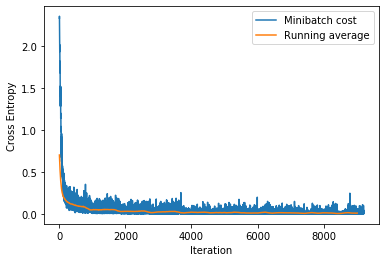

In [29]:
plt.plot(loss_list, label='Minibatch cost')
plt.plot(np.convolve(loss_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

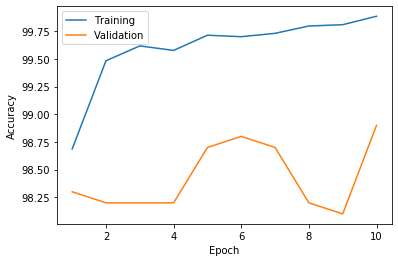

In [30]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [32]:
with torch.set_grad_enabled(False):
    test_acc = compute_accuracy(model=model,
                           data_loader=data_loader["test"],
                           device=DEVICE)
    
    valid_acc = compute_accuracy(model=model,
                            data_loader=data_loader["val"],
                            device=DEVICE)
    

print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')

Validation ACC: 98.90%
Test ACC: 99.10%


## Reference

- https://towardsdatascience.com/understanding-and-visualizing-densenets-7f688092391a
- https://github.com/rasbt/deeplearning-models